## Experiments on three Toy data

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Generate dataset (choose one of them)

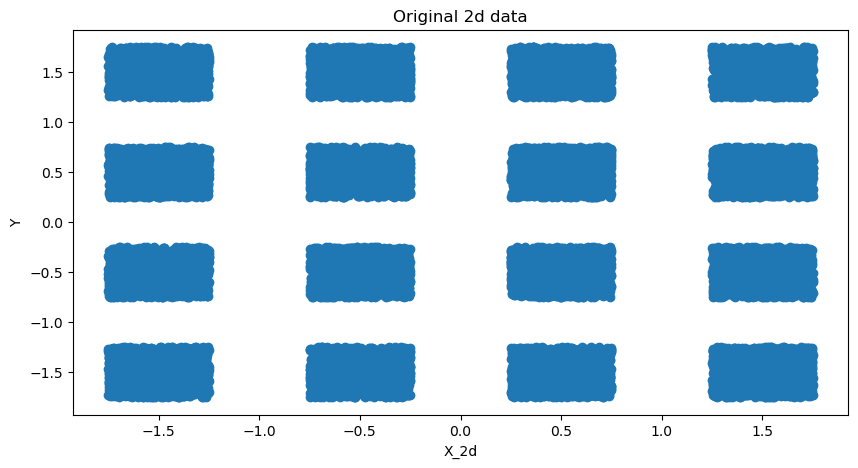

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

n_samples = 100000

import numpy as np
import matplotlib.pyplot as plt

def make_sparse_checkerboard(n_samples, n_grid):
    x = np.random.rand(n_samples, 2) * n_grid

    x_grid = np.floor(x).astype(int)

    mask = (x_grid[:, 0] % 2 == 0) & (x_grid[:, 1] % 2 == 0)
    x_sparse = x[mask]

    return x_sparse



X_2d= make_sparse_checkerboard(n_samples, n_grid=8)
X_2d= (X_2d -3.5)/2


fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(111)
ax1.scatter(X_2d[:, 0], X_2d[:, 1])
ax1.set_title("Original 2d data")
ax1.set_xlabel("X_2d")
ax1.set_ylabel("Y")


plt.show()


X = torch.tensor(X_2d, dtype=torch.float32) # chessboard data

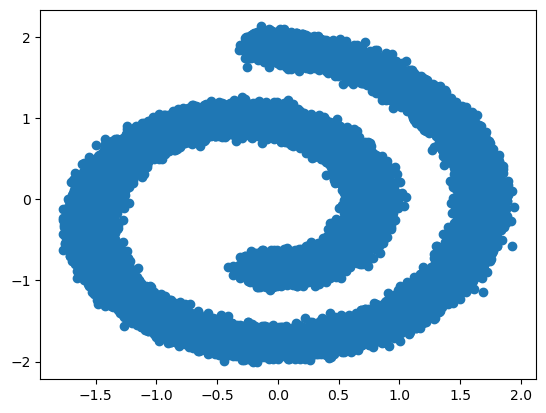

In [2]:
from sklearn.datasets import make_swiss_roll
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

x, _ = make_swiss_roll(n_samples=100000, noise=0.5)
# Make two-dimensional to easen visualization
x = x[:, [0, 2]]

x = (x - x.mean()) / x.std()
plt.scatter(x[:, 0], x[:, 1])
X = torch.tensor(x, dtype=torch.float32) # swissroll data

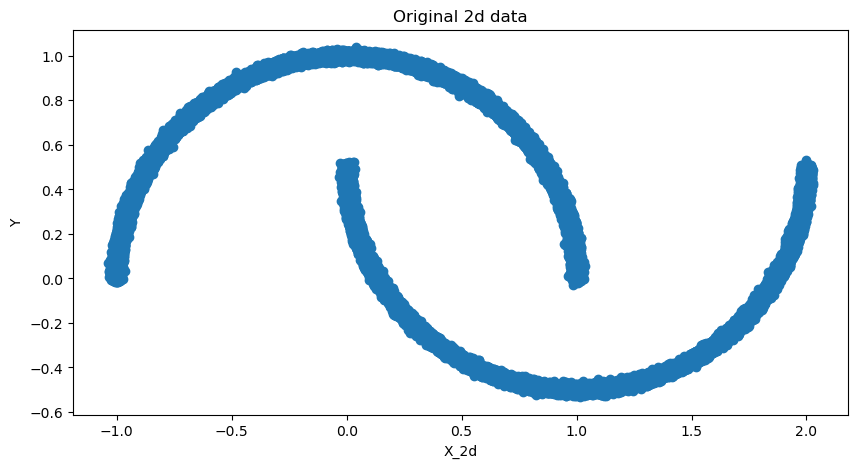

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import torch.nn as nn

n_samples = 100000
X_2d, _ = make_moons(n_samples=n_samples, noise=0.01)

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(111)
ax1.scatter(X_2d[:, 0], X_2d[:, 1])
ax1.set_title("Original 2d data")
ax1.set_xlabel("X_2d")
ax1.set_ylabel("Y")


plt.show()


X = torch.tensor(X_2d, dtype=torch.float32) # moons data

## Diffusion network

In [2]:
import torch.nn as nn

class DiffusionBlock(nn.Module):
    def __init__(self, nunits):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(nunits, nunits)
        
    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        x = nn.functional.relu(x)
        return x
        
    
class DiffusionModel(nn.Module):
    def __init__(self, nfeatures: int, nblocks: int = 2, nunits: int = 64):
        super(DiffusionModel, self).__init__()
        
        self.inblock = nn.Linear(nfeatures+1, nunits)
        self.midblocks = nn.ModuleList([DiffusionBlock(nunits) for _ in range(nblocks)])
        self.outblock = nn.Linear(nunits, nfeatures)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        val = torch.hstack([x, t])  # Add t to inputs
        val = self.inblock(val)
        for midblock in self.midblocks:
            val = midblock(val)
        val = self.outblock(val)
        return val

## Train denoising network

In [3]:
## DDPM schedule

import torch.optim as optim
import seaborn as sns

diffusion_steps = 40  # Number of steps in the diffusion process; 
# To reproduce result in SLDM paper, please use diffusion_steps = 40 for moons, swissroll and 100 for chessboard

# Set noising variances betas as in Nichol and Dariwal paper (https://arxiv.org/pdf/2102.09672.pdf)
s = 0.008
timesteps = torch.tensor(range(0, diffusion_steps), dtype=torch.float32)
schedule = torch.cos((timesteps / diffusion_steps + s) / (1 + s) * torch.pi / 2)**2

baralphas = schedule / schedule[0]
betas = 1 - baralphas / torch.concatenate([baralphas[0:1], baralphas[0:-1]])
alphas = 1 - betas
# -------------------------------------------------
model_ddpm = DiffusionModel(nfeatures=2, nblocks=4)
device = "cuda"
model_ddpm = model_ddpm.to(device)

def noise(Xbatch, t):
    eps = torch.randn(size=Xbatch.shape)
    noised = (baralphas[t] ** 0.5).repeat(1, Xbatch.shape[1]) * Xbatch + ((1 - baralphas[t]) ** 0.5).repeat(1, Xbatch.shape[1]) * eps
    return noised, eps


nepochs = 100  # To reproduce result in SLDM paper, please use 100 for moons and swissroll; 600 for chessboard
batch_size = 2048

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model_ddpm.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=nepochs)
loss_history_ddpm = []
for epoch in range(nepochs):
    epoch_loss = steps = 0
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        timesteps = torch.randint(0, diffusion_steps, size=[len(Xbatch), 1])
        noised, eps = noise(Xbatch, timesteps)
        predicted_noise = model_ddpm(noised.to(device), timesteps.to(device))
        loss = loss_fn(predicted_noise, eps.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss
        steps += 1
    avg_loss = epoch_loss / steps
    loss_history_ddpm.append(avg_loss.cpu().detach().numpy()) 
    print(f"Epoch {epoch} loss = {epoch_loss / steps}")

Epoch 0 loss = 0.7207922339439392
Epoch 1 loss = 0.42820581793785095
Epoch 2 loss = 0.40509000420570374
Epoch 3 loss = 0.3954521715641022
Epoch 4 loss = 0.3889768421649933
Epoch 5 loss = 0.38254889845848083
Epoch 6 loss = 0.3779027462005615
Epoch 7 loss = 0.37524786591529846
Epoch 8 loss = 0.3650987446308136
Epoch 9 loss = 0.37054765224456787
Epoch 10 loss = 0.36239057779312134
Epoch 11 loss = 0.36137470602989197
Epoch 12 loss = 0.3584196865558624
Epoch 13 loss = 0.36001530289649963
Epoch 14 loss = 0.3562014102935791
Epoch 15 loss = 0.35586896538734436
Epoch 16 loss = 0.35357460379600525
Epoch 17 loss = 0.34828609228134155
Epoch 18 loss = 0.3498113453388214
Epoch 19 loss = 0.35095205903053284
Epoch 20 loss = 0.3471637964248657
Epoch 21 loss = 0.3436831831932068
Epoch 22 loss = 0.3381121754646301
Epoch 23 loss = 0.3452970087528229
Epoch 24 loss = 0.3410763442516327
Epoch 25 loss = 0.34230226278305054
Epoch 26 loss = 0.33981648087501526
Epoch 27 loss = 0.33783724904060364
Epoch 28 loss =

SLDM $$x\sim N((1-t)x_0, σ_{min}^2I)$$

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt

sigma_min = torch.tensor(0.05)
# diffusion_steps = 40  # Number of steps in the diffusion process


timesteps = torch.tensor(range(0, diffusion_steps), dtype=torch.float32)
schedule = 1 - timesteps / diffusion_steps # mu=1-t

def noise2(Xbatch, t):
    eps = torch.randn(size=Xbatch.shape)
    noised = schedule[t].repeat(1, Xbatch.shape[1]) * Xbatch + sigma_min.repeat(1, Xbatch.shape[1]) * eps
    return noised, eps


import torch.optim as optim
model_str = DiffusionModel(nfeatures=2, nblocks=4)
device = "cuda"
model_str = model_str.to(device)

# nepochs = 100
# batch_size = 2048

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model_str.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=nepochs)

loss_history_str = []
for epoch in range(nepochs):
    epoch_loss = steps = 0
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        timesteps = torch.randint(0, diffusion_steps, size=[len(Xbatch), 1])
        noised, eps = noise2(Xbatch, timesteps)
        predicted_noise = model_str(noised.to(device), timesteps.to(device))
        loss = loss_fn(predicted_noise, eps.to(device))    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss
        steps += 1
    avg_loss = epoch_loss / steps
    loss_history_str.append(avg_loss.cpu().detach().numpy())
    print(f"Epoch {epoch} loss = {epoch_loss / steps}")



Epoch 0 loss = 0.9945501685142517
Epoch 1 loss = 0.9948624968528748
Epoch 2 loss = 0.9774106740951538
Epoch 3 loss = 0.9685532450675964
Epoch 4 loss = 0.9545820951461792
Epoch 5 loss = 0.9537211060523987
Epoch 6 loss = 0.9842577576637268
Epoch 7 loss = 0.9529576301574707
Epoch 8 loss = 0.9157151579856873
Epoch 9 loss = 0.9289155602455139
Epoch 10 loss = 0.9047934412956238
Epoch 11 loss = 0.9177606105804443
Epoch 12 loss = 0.9313520789146423
Epoch 13 loss = 0.9511337876319885
Epoch 14 loss = 0.9596192836761475
Epoch 15 loss = 0.9436880946159363
Epoch 16 loss = 0.9387379884719849
Epoch 17 loss = 0.938741147518158
Epoch 18 loss = 0.9054907560348511
Epoch 19 loss = 0.9240937232971191
Epoch 20 loss = 0.8943950533866882
Epoch 21 loss = 0.9651528000831604
Epoch 22 loss = 0.946797788143158
Epoch 23 loss = 0.9228646159172058
Epoch 24 loss = 0.9008562564849854
Epoch 25 loss = 0.8737233877182007
Epoch 26 loss = 0.8809418678283691
Epoch 27 loss = 0.9837241172790527
Epoch 28 loss = 0.94180744886398

### BFN

In [ ]:
# schedule = bfn

timesteps = torch.tensor(range(0, diffusion_steps+1), dtype=torch.float32)
gamma = 1-  0.001**(2*(1-(timesteps / diffusion_steps + s) ))
std = ((1 - gamma)*gamma) ** 0.5

def noise(Xbatch, t):
    eps = torch.randn(size=Xbatch.shape)
    noised = (gamma[t]).repeat(1, Xbatch.shape[1]) * Xbatch + (((1 - gamma[t])*gamma[t]) ** 0.5).repeat(1, Xbatch.shape[1]) * eps
    return noised, eps
# ---------------------------------------------
model_bfn = DiffusionModel(nfeatures=2, nblocks=4)
device = "cuda"
model_bfn = model_bfn.to(device)

# nepochs = 100
# batch_size = 2048

loss_fn = nn.MSELoss(reduction='none')  # reduction='none' for loss per sample
optimizer = optim.Adam(model_bfn.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=nepochs)

loss_history_bfn=[]
for epoch in range(nepochs):
    epoch_loss = steps = 0
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        timesteps = torch.randint(0, diffusion_steps, size=[len(Xbatch), 1])
        noised, eps = noise(Xbatch, timesteps)
        predicted_noise = model_bfn(noised.to(device), timesteps.to(device))   

        loss_per_sample = loss_fn(predicted_noise, eps.to(device)).mean(dim=1)
        weights = -torch.log(torch.tensor(0.001))/gamma[timesteps] #continous
        # weights = diffusion_steps * (1- 0.001**(2 / diffusion_steps )) / (2*0.001**(2 * timesteps/ diffusion_steps )) #discrete
        weighted_loss_per_sample = loss_per_sample * weights.to(device)
        loss = weighted_loss_per_sample.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss
        steps += 1
    avg_loss = epoch_loss / steps
    loss_history_bfn.append(avg_loss.cpu().detach().numpy())
    print(f"Epoch {epoch} loss = {epoch_loss / steps}")


Epoch 0 loss = 8.050848007202148
Epoch 1 loss = 7.737877368927002
Epoch 2 loss = 7.632843971252441
Epoch 3 loss = 7.4473795890808105
Epoch 4 loss = 7.381930351257324
Epoch 5 loss = 7.324001312255859
Epoch 6 loss = 7.186857223510742
Epoch 7 loss = 7.189725875854492
Epoch 8 loss = 7.062775611877441
Epoch 9 loss = 7.019550323486328
Epoch 10 loss = 6.9405059814453125
Epoch 11 loss = 6.864258766174316
Epoch 12 loss = 6.860978126525879
Epoch 13 loss = 6.878015041351318
Epoch 14 loss = 6.741036415100098
Epoch 15 loss = 6.736188888549805
Epoch 16 loss = 6.734988212585449
Epoch 17 loss = 6.66786527633667
Epoch 18 loss = 6.645771026611328
Epoch 19 loss = 6.6610236167907715
Epoch 20 loss = 6.5814032554626465
Epoch 21 loss = 6.48415994644165
Epoch 22 loss = 6.545677661895752
Epoch 23 loss = 6.452380657196045
Epoch 24 loss = 6.481142044067383
Epoch 25 loss = 6.360183238983154
Epoch 26 loss = 6.397451400756836
Epoch 27 loss = 6.371429920196533
Epoch 28 loss = 6.426629543304443
Epoch 29 loss = 6.2987

## Sampling algorithm

In [6]:
# gamma = 1-  0.001**(2*(1-(timesteps / diffusion_steps + s) ))
def sample_BFN(model, nsamples, nfeatures):
    """Sampler of BFN(continous)"""
    with torch.no_grad():
        x = 0.0 *torch.randn(size=(nsamples, nfeatures)).to(device)
        xt = [x]
        for t in range(diffusion_steps-1, 0, -1):
            predicted_noise = model(x, torch.full([nsamples, 1], t).to(device))
            x = gamma[t-1]/gamma[t]*x + (gamma[t]-gamma[t-1])/torch.sqrt(gamma[t]*(1-gamma[t]))*predicted_noise
            if t > 1: 
                std = torch.sqrt((1-gamma[t-1])/(1-gamma[t])*(gamma[t-1]-gamma[t]) )
                x += std * torch.randn(size=(nsamples, nfeatures)).to(device)
            xt += [x]
        return x, xt

In [7]:
# sigma_min = torch.tensor(0.05)

def sample_str(model, nsamples, nfeatures):
    """Sampler of SLDM"""
    with torch.no_grad():
        x =  sigma_min *torch.randn(size=(nsamples, nfeatures)).to(device) #
        xt = [x]
        for t in range(diffusion_steps-1, 0, -1):
            predicted_noise = model(x, torch.full([nsamples, 1], t).to(device))
            x = 1 / (1-t/diffusion_steps) * (1-(t-1)/diffusion_steps)  * (x - sigma_min*predicted_noise)
            if t > 1:
                x += (torch.sqrt(torch.tensor(2.0))*sigma_min) * torch.randn(size=(nsamples, nfeatures)).to(device)
            xt += [x]
        return x, xt

In [8]:

def sample_ddpm(model, nsamples, nfeatures):
    """Sampler following the Denoising Diffusion Probabilistic Models method by Ho et al (Algorithm 2)"""
    with torch.no_grad():
        x = torch.randn(size=(nsamples, nfeatures)).to(device)
        xt = [x]
        for t in range(diffusion_steps-1, 0, -1):
            predicted_noise = model(x, torch.full([nsamples, 1], t).to(device))
            # See DDPM paper between equations 11 and 12
            x = 1 / (alphas[t] ** 0.5) * (x - (1 - alphas[t]) / ((1-baralphas[t]) ** 0.5) * predicted_noise)
            if t > 1:
                variance = betas[t]
                std = variance ** (0.5)
                x += std * torch.randn(size=(nsamples, nfeatures)).to(device)
            xt += [x]
        return x, xt

## Test generation

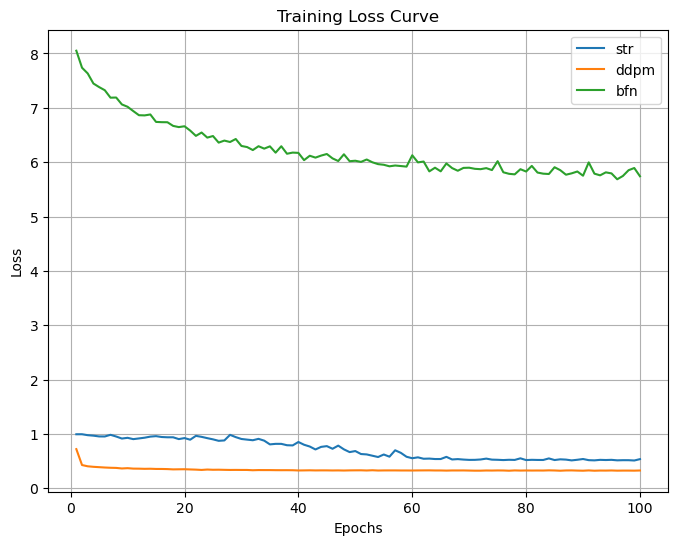

In [9]:
# plot Loss curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, nepochs + 1), loss_history_str, label='str')
plt.plot(range(1, nepochs + 1), loss_history_ddpm,  label='ddpm')
plt.plot(range(1, nepochs + 1), loss_history_bfn,  label='bfn')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid()
plt.show()

In [10]:
# device = "cuda"
Xgen1, Xgen_hist1 = sample_ddpm(model_ddpm, 10000, 2)
Xgen1 = Xgen1.cpu()

Xgen2, Xgen_hist2 = sample_str(model_str, 10000, 2)
Xgen2 = Xgen2.cpu()

Xgen3, Xgen_hist3 = sample_BFN(model_bfn, 10000, 2)
Xgen3 = Xgen3.cpu()



[Text(-1.0, 0, '-1.0'),
 Text(0.0, 0, '0.0'),
 Text(1.0, 0, '1.0'),
 Text(2.0, 0, '2.0')]

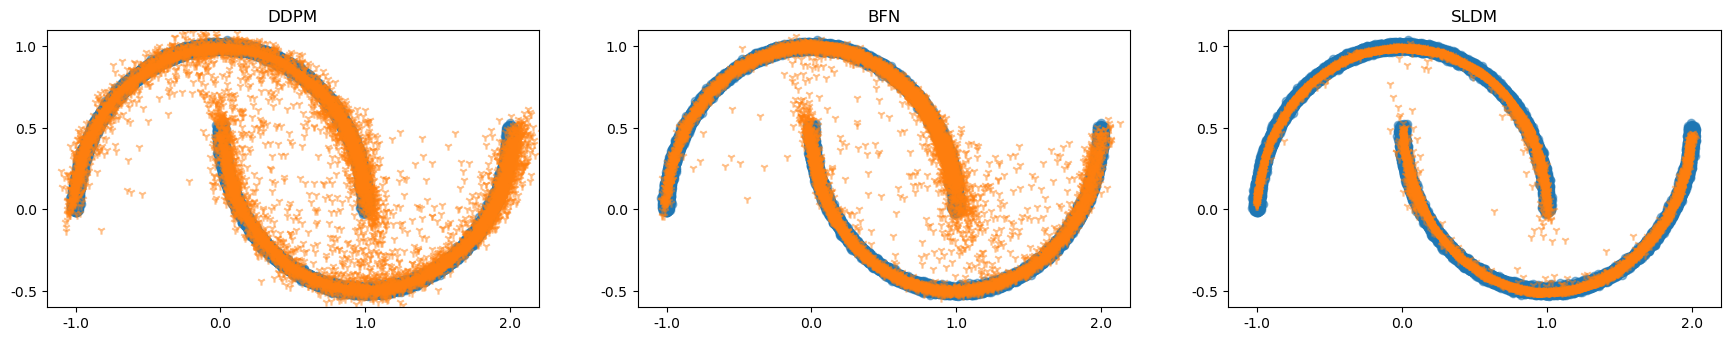

In [12]:

# draw moons
fig, axs = plt.subplots(1, 3, figsize=(36*0.6, 6*0.6))

axs[0].scatter(X[:, 0], X[:, 1], alpha=0.5, label='Original Data')
axs[0].scatter(Xgen1[:, 0], Xgen1[:, 1], marker='1', alpha=0.5,label='Generated Data')
axs[0].set_title('DDPM')
# axs[2].legend(loc='upper right',fontsize=28)
axs[0].set_ylim(-0.6,1.1) #(-0.1,1.1) #(-0.5,10.5)#
axs[0].set_xlim(-1.2,2.2)
axs[0].set_yticks(np.arange(-0.5,1.5,0.5))  # Define the tick positions
axs[0].set_yticklabels(np.arange(-0.5,1.5,0.5))  # Define the labels and font size
axs[0].set_xticks(np.arange(-1.0,2.2,1))  # Define the tick positions
axs[0].set_xticklabels(np.arange(-1,2.2,1))  # Define the labels and font size


axs[1].scatter(X[:, 0], X[:, 1], alpha=0.5, label='Original Data')
axs[1].scatter(Xgen3[:, 0], Xgen3[:, 1], marker='1', alpha=0.5, label='Generated Data')
axs[1].set_title('BFN')
# axs[2].legend(loc='upper right',fontsize=28)
axs[1].set_ylim(-0.6,1.1) #(-0.1,1.1) #(-0.5,10.5)#
axs[1].set_xlim(-1.2,2.2)
axs[1].set_yticks(np.arange(-0.5,1.5,0.5))  # Define the tick positions
axs[1].set_yticklabels(np.arange(-0.5,1.5,0.5))  # Define the labels and font size
axs[1].set_xticks(np.arange(-1.0,2.2,1))  # Define the tick positions
axs[1].set_xticklabels(np.arange(-1,2.2,1))  # Define the labels and font size


axs[2].scatter(X[:, 0], X[:, 1], alpha=0.5, label='Original Data')
axs[2].scatter(Xgen2[:, 0], Xgen2[:, 1], marker='1', alpha=0.5, label='Generated Data')
axs[2].set_title('SLDM')
# axs[2].legend(loc='upper right',fontsize=28)
axs[2].set_ylim(-0.6,1.1) #(-0.1,1.1) #(-0.5,10.5)#
axs[2].set_xlim(-1.2,2.2)
axs[2].set_yticks(np.arange(-0.5,1.5,0.5))  # Define the tick positions
axs[2].set_yticklabels(np.arange(-0.5,1.5,0.5))  # Define the labels and font size
axs[2].set_xticks(np.arange(-1.0,2.2,1))  # Define the tick positions
axs[2].set_xticklabels(np.arange(-1,2.2,1))  # Define the labels and font size

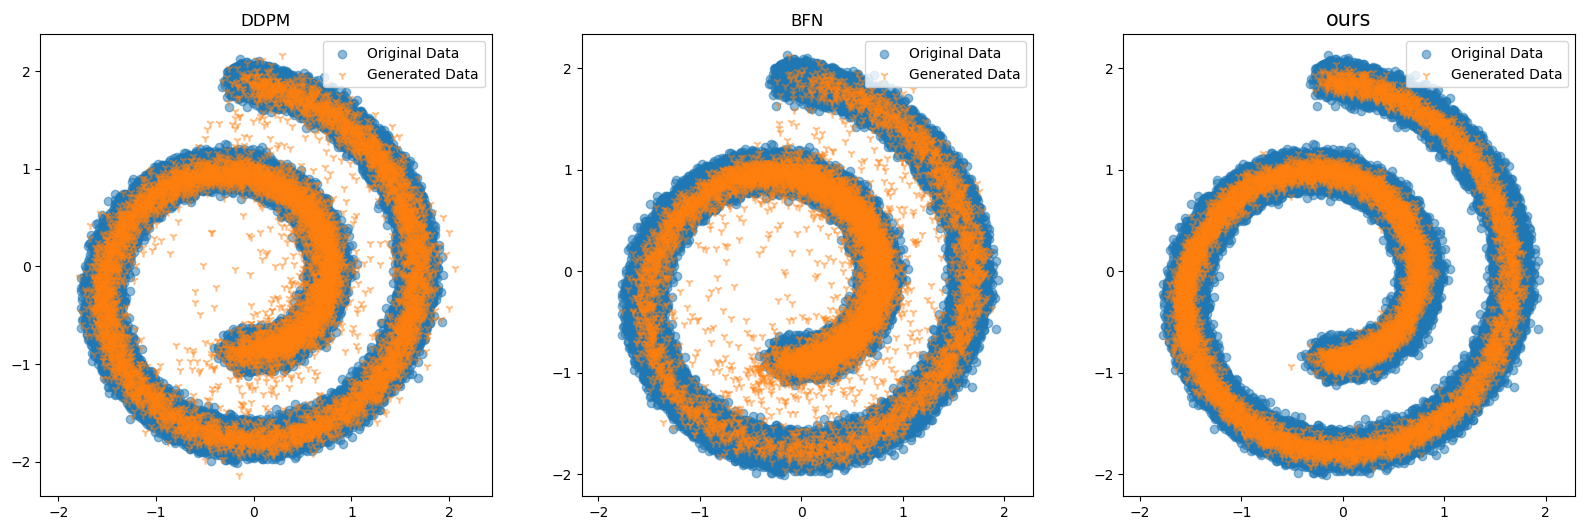

In [ ]:
# plot for swissroll data
fig, axs = plt.subplots(1, 3, figsize=(33*0.6, 10*0.6))


axs[0].scatter(X[:, 0], X[:, 1], alpha=0.5, label='Original Data')
axs[0].scatter(Xgen1[:, 0], Xgen1[:, 1], marker='1', alpha=0.5, label='Generated Data')
axs[0].set_title('DDPM')
axs[0].legend(loc='upper right')
axs[0].set_ylim(-2.2,2.2)
axs[0].set_xlim(-2.2,2.2)
axs[0].axis('equal')
axs[0].set_xticks(np.arange(-2, 3,1))
axs[0].set_yticks(np.arange(-2, 3,1))


axs[1].scatter(X[:, 0], X[:, 1], alpha=0.5, label='Original Data')
axs[1].scatter(Xgen3[:, 0], Xgen3[:, 1], marker='1', alpha=0.5, label='Generated Data')
axs[1].set_title('BFN')
axs[1].legend(loc='upper right')
axs[1].set_ylim(-2.2,2.2)
axs[1].set_xlim(-2.2,2.2)
axs[1].axis('equal')
axs[1].set_xticks(np.arange(-2, 3,1))
axs[1].set_yticks(np.arange(-2, 3,1))


axs[2].scatter(X[:, 0], X[:, 1], alpha=0.5, label='Original Data')
axs[2].scatter(Xgen2[:, 0], Xgen2[:, 1], marker='1', alpha=0.5, label='Generated Data')
axs[2].set_title('ours', fontsize=15)
axs[2].legend(loc='upper right')
axs[2].set_ylim(-2.2,2.2)
axs[2].set_xlim(-2.2,2.2)
axs[2].axis('equal')
axs[2].set_xticks(np.arange(-2, 3,1))
axs[2].set_yticks(np.arange(-2, 3,1))

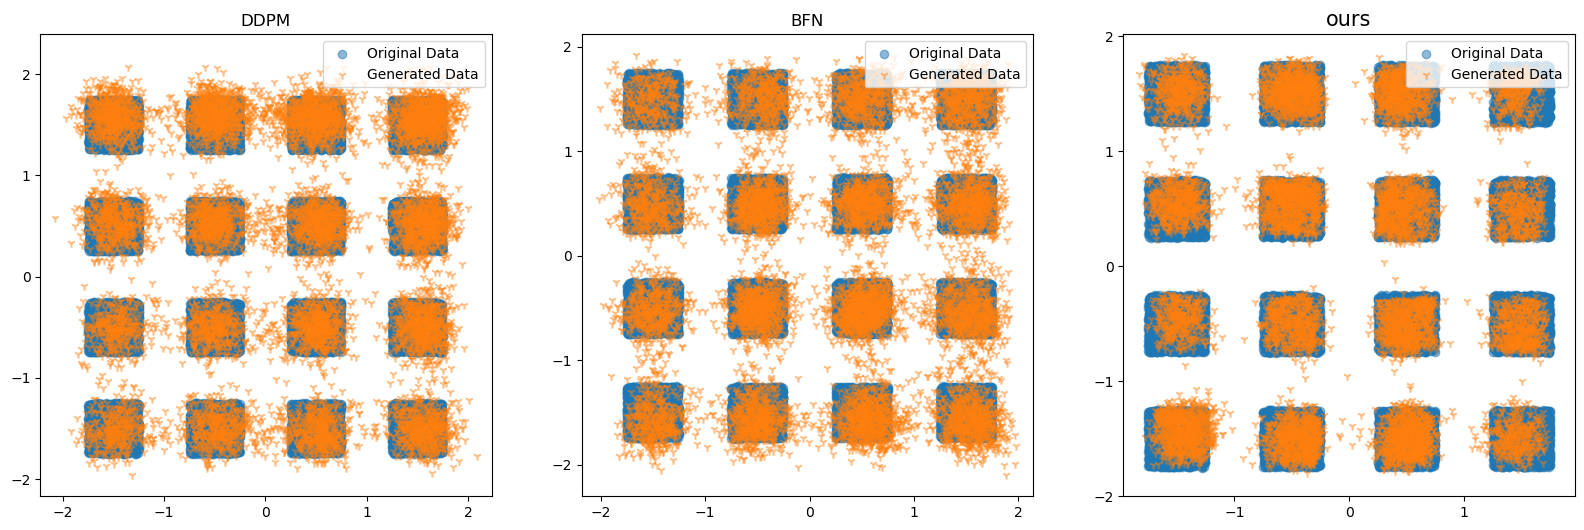

In [ ]:
# plot for chessboard data
fig, axs = plt.subplots(1, 3, figsize=(33*0.6, 10*0.6))


axs[0].scatter(X[:, 0], X[:, 1], alpha=0.5, label='Original Data')
axs[0].scatter(Xgen1[:, 0], Xgen1[:, 1], marker='1', alpha=0.5, label='Generated Data')
axs[0].set_title('DDPM')
axs[0].legend(loc='upper right')
axs[0].set_ylim(-2.2,2.2)
axs[0].set_xlim(-2.2,2.2)
axs[0].axis('equal')
axs[0].set_xticks(np.arange(-2, 3,1))
axs[0].set_yticks(np.arange(-2, 3,1))


axs[1].scatter(X[:, 0], X[:, 1], alpha=0.5, label='Original Data')
axs[1].scatter(Xgen3[:, 0], Xgen3[:, 1], marker='1', alpha=0.5, label='Generated Data')
axs[1].set_title('BFN')
axs[1].legend(loc='upper right')
axs[1].set_ylim(-2.2,2.2)
axs[1].set_xlim(-2.2,2.2)
axs[1].axis('equal')
axs[1].set_xticks(np.arange(-2, 3,1))
axs[1].set_yticks(np.arange(-2, 3,1))


axs[2].scatter(X[:, 0], X[:, 1], alpha=0.5, label='Original Data')
axs[2].scatter(Xgen2[:, 0], Xgen2[:, 1], marker='1', alpha=0.5, label='Generated Data')
axs[2].set_title('ours', fontsize=15)
axs[2].legend(loc='upper right')
axs[2].set_ylim(-2.2,2.2)
axs[2].set_xlim(-2.2,2.2)
axs[2].axis('equal')
axs[2].set_xticks(np.arange(-2, 3,1))
axs[2].set_yticks(np.arange(-2, 3,1))

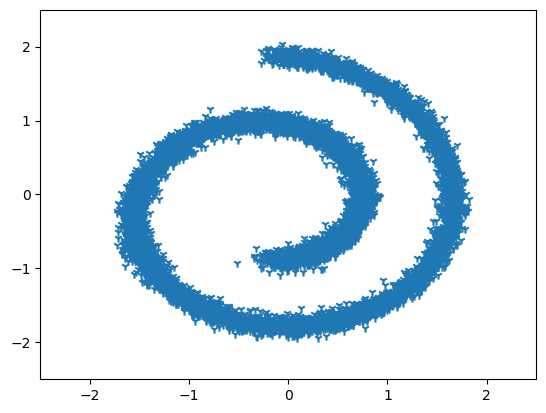

In [15]:
import matplotlib.animation as animation

def draw_frame(i):
    plt.clf()
    Xvis = Xgen_hist2[i].cpu()
    fig = plt.scatter(Xvis[:, 0], Xvis[:, 1], marker="1", animated=True)
    plt.xlim([-2.5, 2.5])
    plt.ylim([-2.5, 2.5])
    return fig,

fig = plt.figure()
anim = animation.FuncAnimation(fig, draw_frame, frames=40, interval=20, blit=True)
anim.save('str.gif', fps=10)